# Machine Learning in Python - Workshop 6

# 1. Setup


## 1.1 Packages


In the cell below we will load the core libraries we will be using for this workshop and setting some sensible defaults for our plot size and resolution. 

In [1]:
# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.dpi'] = 80

# ipython interactive widgets
from ipywidgets import interact

# sklearn modules
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold

--- 

# 2. Kernel Ridge Regression

This is an approach that combines Ridge regression with the kernel trick to allow for the fitting of more complex relationships. Beginning with the Ridge regression optimization formulation,

$$ \underset{\boldsymbol{\beta}}{\text{argmin}} \; \lVert \boldsymbol{y} - \boldsymbol{X} \boldsymbol{\beta} \rVert^2 + \alpha (\boldsymbol{\beta}^T\boldsymbol{\beta}) $$ 

We have seen that it has a closed form solution where

$$ \boldsymbol{\beta} = \left( \boldsymbol{X}\boldsymbol{X}^\top + \alpha \boldsymbol{I}_p \right)^{-1} \boldsymbol{X}^\top \boldsymbol{y} $$

which can be rewritten as 

$$ 
\begin{align}
\boldsymbol{\beta} 
    &= \boldsymbol{X}^\top \left( \boldsymbol{X}^\top\boldsymbol{X} + \alpha \boldsymbol{I}_p \right)^{-1}  \boldsymbol{y} \\
    &= \boldsymbol{X}^\top \left( \boldsymbol{K} + \alpha \boldsymbol{I}_p \right)^{-1}  \boldsymbol{y}
\end{align}
$$

where $\boldsymbol{K}$ is a Gram matrix defined by a given kernel.

The implementation in scikit-learn is provided by the `KernelRidge` function in the `sklearn.kernel_ridge` submodule.

In [2]:
from sklearn.kernel_ridge import KernelRidge

We will use this model to fit the gaussian process data we originally examined in week 3.

In [3]:
gp = pd.read_csv('gp.csv').sample(frac=1)

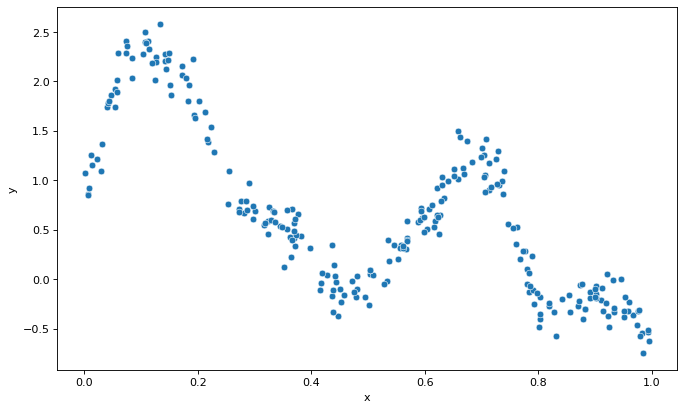

In [4]:
sns.scatterplot(x='x', y='y', data=gp)
plt.show()

In [5]:
# Define outcome vector and model matrix
y = gp.y
X = gp.drop('y', axis=1)

## 2.1 Model Parameters

To fit a kernel ridge regression model we first must choose a kernel function, here we will be using a radial basis function (`rbf`), other possible choices are available as part of the `sklearn.metrics.pairwise` submodule. Each kernel will have additional parameters, generally sklearn attempts to label all primary kernel parameters using the name `gamma` and any additional required parameters will have more informative names. In class this parameter was referred to as the bandwidth and given the name $l$. The parameterization of the radial basis function used by scikit-learn is as follows:

$$K(\boldsymbol{x}, \boldsymbol{y}) = \exp(-\gamma \lVert \boldsymbol{x}-\boldsymbol{y} \rVert^2).$$

As such, when fitting a rbf based kernel ridge regression model we now have two parameters to optimize over: `alpha` from the ridge $\ell_2$ penalty, and `gamma` the bandwidth of the rbf kernel.

Below we define a function that fits the kernel ridge regression to the `gp` data and then plots the fit along with reporting the root mean squared error. By including the `interact` decorator we provide simple interactive widgets that you can use to adjust these two parameters to explore their effect on the model's fit.

In [8]:
def kernel_ridge_fit(alpha, gamma):
    # Fit the model
    m = KernelRidge(kernel='rbf', alpha=alpha, gamma=gamma).fit(X, y)

    rmse = np.sqrt(mean_squared_error(y, m.predict(X)))

    # Create DF for predictions
    gp_pred = pd.DataFrame({'x': np.linspace(0, 1, num=100)})
    gp_pred["y"] = m.predict(gp_pred)

    sns.scatterplot(x='x', y='y', data=gp)
    sns.lineplot(x='x', y='y', data=gp_pred, color='black')
    plt.title("alpha = %s gamma = %.1f\nrmse = %.4f" % (alpha, gamma, rmse))
    plt.show()


You can try adjusting the values of these parameters in the code chunk below and exploring the effect they have on the overall model fit. We recommend trying values of `alpha` between 0 and 1 and `gamma` between 0 and 1000. Note the behavior of `gamma` will depend on your choice of `alpha`.

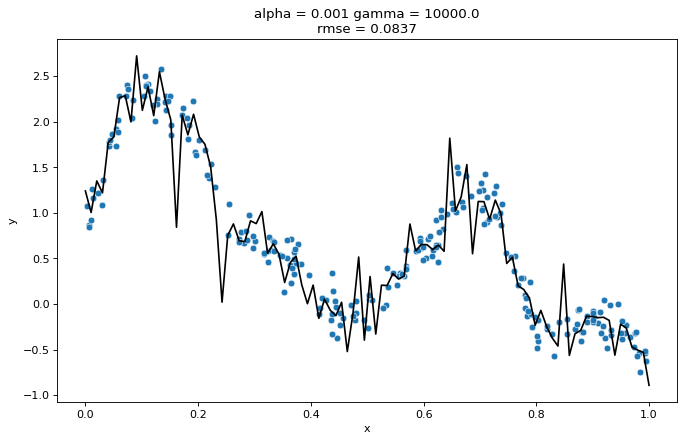

In [17]:
kernel_ridge_fit(alpha = 0.001, gamma = )

---

### &diams; Exercise 1

How does changing the value of `alpha` and `gamma` affect the fit of this model? Which of the two seems more important? Explain.

---

## 2.2 Model Tuning

As with ridge and lasso regression models we can use `GridSearchCV` to explore the space of possible parameters to determine the optimal model under cross validation. 

In [18]:
m = GridSearchCV(
    KernelRidge(kernel='rbf'),
    param_grid={"alpha": np.logspace(-3, 0, num=4),
                "gamma": np.logspace(0, 3, num=50)},
    scoring = 'neg_mean_squared_error', 
    cv = KFold(5, shuffle=True, random_state=1234)
)

m = m.fit(X,y)

Note that with two parameters we now need to fit $n_\alpha \times n_\gamma \times n_{cv}$ models which can be somewhat slow. For our grid search we obtain the following as the best values of these parameters:

In [19]:
m.best_params_

{'alpha': 0.01, 'gamma': 138.94954943731375}

Once the parameter values have been determined we can then examine the model's performance with the entire data set using the `kernel_ridge_fit` function we previously defined.

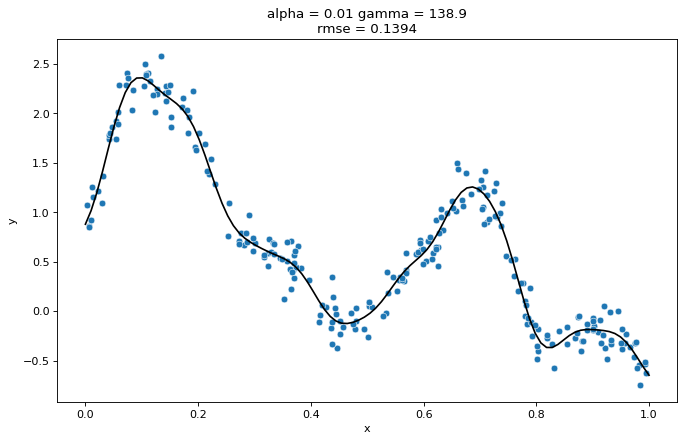

In [20]:
kernel_ridge_fit(m.best_params_["alpha"], m.best_params_["gamma"])

---

### &diams; Exercise 2

Repeat the grid search above but fix `alpha` to be 0.01, 0.1 and 1 and search over the possible values of `gamma`. For each of these three models compare the rmse of the model on the entire data set.

In [ ]:
# alpha = 0.01

In [ ]:
# alpha = 0.1

In [21]:
# alpha = 1

---

### &diams; Exercise 3

Based on your finding in Exercise 2 comment on the relative importance of `alpha` for the performance of the model.

---

### &diams; Exercise 4

What happens if you set `alpha = 0`?

---

# 3. Logistic Regression (Introduction)
 
## 3.1 Data

For this introduction we will be using a data set on spam emails from the [OpenIntro project](https://www.openintro.org/), these data are similar in spirit to those used in lecture (which came from Machine Learning: A Probabilistic Perspective). These data have been provided as `email.csv` along with this worksheet. A full data dictionary can be found [here](https://www.openintro.org/data/index.php?data=email). To keep things simple this week we will restrict our exploration to including only the following columns: `spam`, `exclaim_mess`, `format`, `num_char`,  `line_breaks`, and `number`. Brief descriptions of these variables are below:

* `spam` - Indicator for whether the email was spam.
* `exclaim_mess` - The number of exclamation points in the email message.
* `format` - Indicates whether the email was written using HTML (e.g. may have included bolding or active links).
* `num_char` - The number of characters in the email, in thousands.
* `line_breaks` - The number of line breaks in the email (does not count text wrapping).
* `number` - Factor variable saying whether there was no number, a small number (under 1 million), or a big number.

In [22]:
email = pd.read_csv('email.csv')[ ['spam', 'exclaim_mess', 'format', 'num_char', 'line_breaks', 'number'] ]
email

,spam,exclaim_mess,format,num_char,line_breaks,number
0,0,0,1,11.370,202,big
1,0,1,1,10.504,202,small
2,0,6,1,7.773,192,small
3,0,48,1,13.256,255,small
4,0,1,0,1.231,29,none
...,...,...,...,...,...,...
3916,1,0,0,0.332,12,small
3917,1,0,0,0.323,15,small
3918,0,5,1,8.656,208,small
3919,0,0,0,10.185,132,small


Given that our data includes the `number` column which is categorical, we will take care of the necessary dummy coding (specifically one hot encoding here) before we begin to explore and model these data. Here we will use the pandas' `get_dummies` function but a similar outcome can be achieved using sklearn's `OneHotEncoder`.

In [24]:
email = pd.get_dummies(email)
email

,spam,exclaim_mess,format,num_char,line_breaks,number_big,number_none,number_small
0,0,0,1,11.370,202,1,0,0
1,0,1,1,10.504,202,0,0,1
2,0,6,1,7.773,192,0,0,1
3,0,48,1,13.256,255,0,0,1
4,0,1,0,1.231,29,0,1,0
...,...,...,...,...,...,...,...,...
3916,1,0,0,0.332,12,0,0,1
3917,1,0,0,0.323,15,0,0,1
3918,0,5,1,8.656,208,0,0,1
3919,0,0,0,10.185,132,0,0,1


---

## 3.2 Exploration

We can construct a pair plot of these data to explore some of the basic relationships between the outcome and the features, since our outcome variable, `spam`, is binary (categorical) we can use it is as the `hue` argument with the `pairplot` function to get a better sense about how spam and non-spam messages differ across our features.

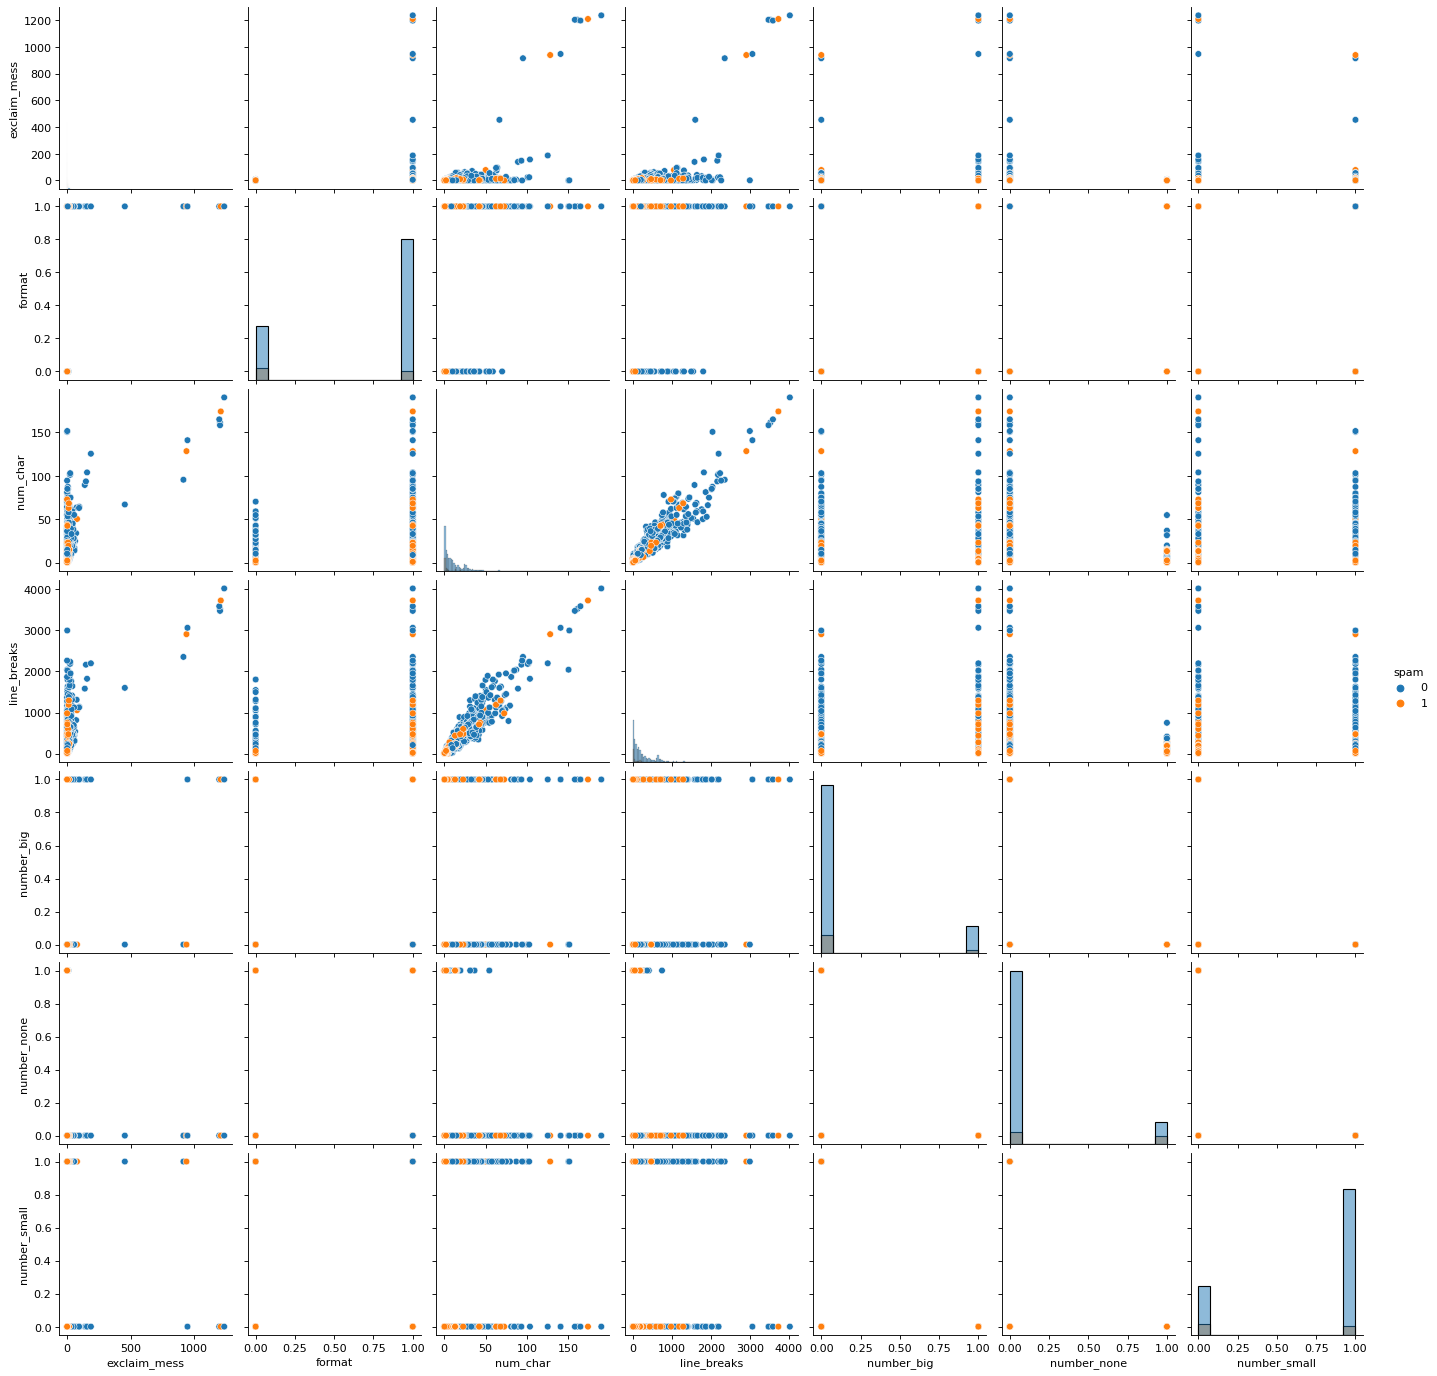

In [25]:
sns.pairplot(email, hue='spam', diag_kind='hist')

---

### &diams; Exercise 5

Of the plots provided by the pair plot which are the most useful? Explain.

---

When plotting data with categorical or binary features there are a number of additional plotting methods in seaborn that are useful for exploring potential relationships. In particular, `stripplot`, `swarmplot` and `violinplot` can all provide useful insights while avoiding the overplotting issue.

Another useful type of plot for data like this is known as a strip plot which adds jitter to avoid the overplotting while showing "all" of the data, which is particularly important when your categories are not balanced.

In [30]:
# Since some methods show all points, we will sample the data to get a more managable n
# swarmplot in particular is very slow for large n

email_samp = email.sample(frac=0.1, random_state=1234)

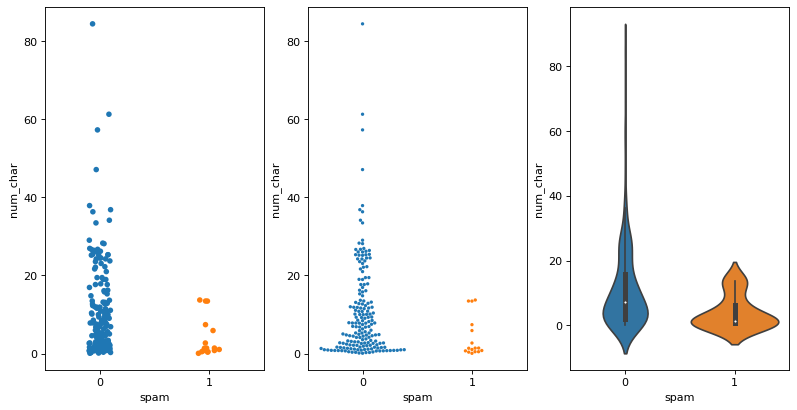

In [34]:
plt.figure(figsize=(12,6))

plt.subplot(131)
sns.stripplot(y='num_char', x='spam', data=email_samp)

plt.subplot(132)
sns.swarmplot(y='num_char', x='spam', size=3, data=email_samp)

plt.subplot(133)
sns.violinplot(y='num_char', x='spam', data=email_samp)

plt.show()

---

### &diams; Exercise 6

Comment on any structure you see in these plots, does `num_char` appear to have different distributions between the spam and non-spam emails?

---

Since the `num_char` variable is quite right skewed we can explore using a log transform of the variable before plotting,

In [48]:
email_samp['log_num_char'] = np.log(email_samp.num_char)

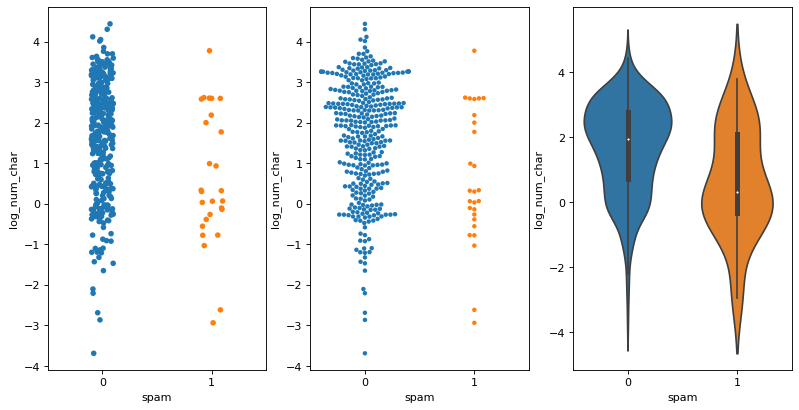

In [49]:
plt.figure(figsize=(12,6))

plt.subplot(131)
sns.stripplot(y='log_num_char', x='spam', data=email_samp)

plt.subplot(132)
sns.swarmplot(y='log_num_char', x='spam', size=4, data=email_samp)

plt.subplot(133)
sns.violinplot(y='log_num_char', x='spam', data=email_samp)

plt.show()

---

### &diams; Exercise 7

Comment on any structure you see in these plots, does `log_num_char` appear to have different distributions between the spam and non-spam emails?

---

## 3.2 Model Fitting

Logistic (and multinomial) regression models are fit using the `LogisticRegression` model function from the `linear_model` submodule of sklearn. 

In [41]:
from sklearn.linear_model import LogisticRegression

In [42]:
y = email.spam
X = email.drop('spam', axis=1)

There are a couple of "unique" properties of this model implementation in sklearn that are important to be aware of. The first is that the model can be fit with regularization (i.e. an $\ell_2$ or $\ell_1$ penalty) but the inclusion of the $\ell_2$ penalty is the default behavior for these models. 

For those coming from other programming / modeling languages this may be somewhat surprising, this strange default is probably the most common reason that results from sklearn might not immediately match results from other tools. This behavior can be explicitly controlled via the `penalty` argument. Note that if you did wish to include a penalty on the coefficients then just like with ridge or lasso it is necessary to tune this penalty parameter. However, `LogisticRegression` does not use `alpha` for this tuning parameter but instead uses `C` which is the inverse of the `alpha` we have been using - i.e. smaller values of `C` imply more regularization. 

Otherwise, this model function behaves as all of the other model functions we have seen so far, below we fit the model and then extract the fitted coefficients.

In [47]:
# Note we use `fit_intercept = False` to avoid a rank deficient model matrix sicne
# we used one-hot encoding for the `number` feature.

m = LogisticRegression(penalty = 'none', fit_intercept = False, solver='lbfgs', max_iter=1000).fit(X, y)

In [44]:
# This is just some fancy python code for attaching the column names to 
# their corresponding coefficeint values

dict(zip(X.columns, zip(*m.coef_)))

{'exclaim_mess': (0.004889010611915334,),
 'format': (-0.39595473343417237,),
 'num_char': (0.08679064635519927,),
 'line_breaks': (-0.00492435386258656,),
 'number_big': (-1.197489256108537,),
 'number_none': (-1.045841535328189,),
 'number_small': (-1.9034979492938222,),
 'log_num_char': (-0.3753352301007197,)}

---

### &diams; Exercise 8

Based on these results, interpret the coefficient for `num_char` in context.

---

### &diams; Exercise 9

Generally comment on how each feature is related to the probability of an email being spam.

---

## 3.3 Model Predictions

Unlike with our previous regression models, the fitted `LogisticRegression` objects provide multiple prediction methods. Specifically: `predict` which predicts the class label (either `0` or `1`), `predict_proba` which predicts the class probabilities, and `predict_log_proba` which predicts the log probabilities of each class.

In [53]:
m.predict(X.head())

array([0, 0, 0, 0, 0])

In [50]:
m.predict_proba(X.head())

array([[0.92510261, 0.07489739],
       [0.96304258, 0.03695742],
       [0.96479252, 0.03520748],
       [0.95851403, 0.04148597],
       [0.7604092 , 0.2395908 ]])

In [51]:
m.predict_log_proba(X.head())

array([[-0.07785062, -2.59163624],
       [-0.03765765, -3.29798879],
       [-0.03584221, -3.34649659],
       [-0.04237108, -3.18239992],
       [-0.27389857, -1.42882281]])

Here the class label prediction is based on which of the classes has the largest probability. In this case the model is predicting that all five of these messages are not spam (`spam==0`).

---

### &diams; Exercise 10

According to this model, what is the probability that a message with 5 exclamation marks, unformated, with 5000 characters, 10 line breaks, and no numbers was spam?

---

## 3.3 Model Validation

As our outcome variable of interest is binary, either 0 or 1, using metrics like root mean squared error does not make sense. Instead we use metrics that measure our classifier's ability to correctly label our data using the following possible outcomes for each prediction:

* *true positives* - labeled as spam when it is spam
* *false positives* - labeled as spam when it is not spam
* *true negatives* - labeled as not spam when it is not spam
* *false negatives* - labeled as not spam when it is spam

The `predict` function chooses these labels based on whichever probability is larger, in the binary case this is equivalent to asking if the probability of being spam is $\geq 0.5$ for each observation. This choice of threshold however is arbitrary and we can use any value between 0 and 1 for determining what we will label spam vs not spam. Below we engage is some data book keeping and then define the `confusion_plot` function for visualizing these different outcomes for the different possible threshold values. 

In [54]:
# This transformation is necessary so that seaborn behaves correctly when plotting the data horizontally
truth = pd.Categorical.from_codes(y, categories = ('not spam','spam'))
probs = m.predict_proba(X)[:,1]

In [55]:
def confusion_plot(threshold=0.5):
    d = pd.DataFrame(
        data = {'spam': y, 'truth': truth, 'probs': probs}
    )
    
    # Create a column called outcome that contains the labeling outcome
    # for the given threshold
    d['outcome'] = 'other'
    d.loc[(d.spam == 1) & (d.probs >= threshold), 'outcome'] = 'true positive'
    d.loc[(d.spam == 0) & (d.probs >= threshold), 'outcome'] = 'false positive'
    d.loc[(d.spam == 1) & (d.probs <  threshold), 'outcome'] = 'false negative'
    d.loc[(d.spam == 0) & (d.probs <  threshold), 'outcome'] = 'true negative'
    
    # Create plot and color according to outcome
    plt.figure(figsize=(12,4))
    plt.xlim((-0.05,1.05))
    sns.stripplot(y='truth', x='probs', hue='outcome', data=d)
    plt.axvline(x=threshold, linestyle='dashed', color='black', alpha=0.5)
    plt.title("threshold = %.2f" % threshold)
    plt.show()
    
    return sklearn.metrics.confusion_matrix(y_true=d.spam, y_pred=d.probs >= threshold)

Below we run this function using a threshold of 0.5 to examine how the logistic regression classifier is performing. Feel free to vary this between 0 and 1 and observe the effect.

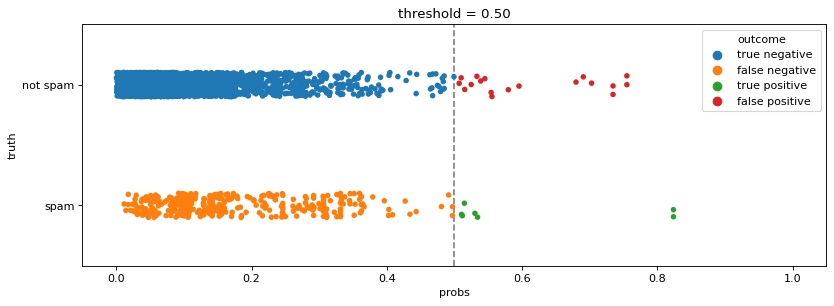

array([[3536,   18],
       [ 360,    7]])

In [56]:
confusion_plot(threshold=0.5)

The small matrix that is returned by the function is the confusion matrix for the given threshold and it contains the number of each outcome (in the same order as presented in the graph), this is calculated use the `confusion_matrix` function from the `sklearn.metrics` submodule.

---

### &diams; Exercise 11

Based on these results what value of threshold for this model might be a reasonable choice? Think about the relative cost of a false negative vs a false positive.

---

### 3.3.1 ROC curves

Another method for seeing the effect of these different choices of threshold is to generate a Receiver operating characteristic (ROC) curve for the model which plots the true positive rate against the false positive rate for different threshold values.

In [57]:
from sklearn.metrics import roc_curve, precision_recall_curve

This function returns a tuple of the false positive rate, true positive rate, and threshold values based on the true labels and the predicted probabilities. 

Here we take those results and construct a data frame to enable us to create the ROC plot using seaborn. 

In [62]:
roc_calc = roc_curve(y_true=y, y_score=probs)

roc = pd.DataFrame(
    data = np.c_[roc_calc],
    columns = ('false positive rate', 'true positive rate', 'threshold')
)

roc

,false positive rate,true positive rate,threshold
0,0.000000,0.000000,1.823762
1,0.000000,0.005450,0.823762
2,0.001125,0.005450,0.734399
3,0.003658,0.005450,0.538798
4,0.003658,0.008174,0.534174
...,...,...,...
603,0.885481,0.994550,0.014366
604,0.885481,0.997275,0.014198
605,0.899550,0.997275,0.011708
606,0.899550,1.000000,0.011700


Using this data frame, the function below creates the ROC curve (blue) via a seaborn lineplot, while the remaining code draws the point on the ROC curve that corresponds to the given threshold value (red), and finally the 0-1 line (grey, dashed). The 0-1 line is the ROC curve expected for a model that determines labels by chance (e.g. flipping a coin with `heads` is spam, `tails` is not spam as a model). 

In [63]:
def roc_plot(threshold=0.5):
    i = (np.abs(roc.threshold - threshold)).idxmin()

    sns.lineplot(x='false positive rate', y='true positive rate', data=roc, ci=None)

    plt.plot([0,1],[0,1], 'k--', alpha=0.5) # 0-1 line 
    plt.plot(roc.iloc[i,0], roc.iloc[i,1], 'r.')

    plt.title("threshold = %.2f" % threshold)
    plt.show()

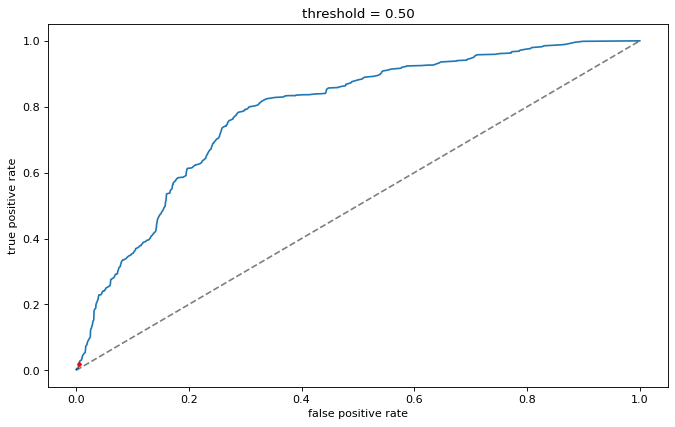

In [64]:
roc_plot(threshold=0.5)

---

### &diams; Exercise 12

Try adjusting the threshold value in `roc_plot`, what happens to the red point as this value is changed?

---

Finally, a common summary statistic that is used to summarize the performance of a binary classifier over all the possible thresholds is the area under the curve (AUC), which as the name implies, is the area under the ROC curve. This can be calculated from the prediction results using the `roc_auc_score` function  from the `sklearn.metrics` submodule.

In [65]:
sklearn.metrics.roc_auc_score(y_true=y, y_score=probs)

0.7858562865804197

Beyond giving a simple numeric summary statistic for a classifier, the AUC also has a useful somewhat interpretable meaning - this value equals the probability that the classifier will rank a randomly chosen positive case (`spam` here) higher than a randomly chosen negative case (`not spam` here).

---

### &diams; Exercise 13

Based on these and the preceeding results, how well does this classifier perform? Justify your answer.

---

Note that the AUC does not tell us what value of threshold should be used for our classifier, just its overall performance. If we would like to choose an optimal threshold value for practical decision making then we need to define a specific loss function for our data / problem. Specifically, we need to have some numeric measure of the benefit for true positives and true negatives and the costs of false negatives and false positives. For example the cost of a false positive vs. false negative is very different for this spam example than it would be for a medical diagnostic test like a Cancer screening test.

---

## 4. Competing the worksheet

At this point you have hopefully been able to complete all the preceeding exercises. Now 
is a good time to check the reproducibility of this document by restarting the notebook's
kernel and rerunning all cells in order.

Once that is done and you are happy with everything, you can then run the following cell 
to generate your PDF and turn it in on gradescope under the `mlp-week06` assignment.

In [ ]:
!jupyter nbconvert --to pdf mlp-week06.ipynb